In [123]:
%pylab inline
import astropy.units as u
import astropy.constants as const
import matplotlib as mpl

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Times New Roman"]
mpl.rcParams["font.size"] = 12

#data = np.genfromtxt('Pos_raw_andLlya.txt')
data = np.genfromtxt('Engine_data.txt')

#taking data from the simulation
Pos_Mpc = data[:,0:3]
L_lya = data[:,3] #case B simple Lya (10**42 SFR)
SFR = data[:,4]
Mass_stel = data[:,5]
Mass_dm = data[:,6]

Populating the interactive namespace from numpy and matplotlib


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['uniform', 'f', 'select', 'exponential', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Assuming case B recombination I have assumed an intrinsic Ly$\alpha$ luminosity given by:
$$L_{\rm Ly\alpha} \ [\rm erg \ s^{-1}]= 10^{42} \cdot {\rm SFR \ [M_\odot \ yr^{-1}]}$$

The UV luminosity was estimated starting from the SFR using the Kennicut relation found in the Madau Dickinson review for a Chabrier IMF, which is the IMF used in EAGLE.

$${\rm SFR [M_\odot \ yr^{-1}]} = 0.63 \cdot 1.4 \cdot 10^{-28} L_{\nu} [\rm erg \ s^{-1} \ Hz^{-1}]$$

$$L_{\nu} d\nu = L_{\lambda} d\lambda$$

$$L_{\lambda} = L_{\nu} \frac{d\nu}{d\lambda} = L_{\nu} \frac{c}{\lambda^2} = \frac{\rm SFR}{1.4 \cdot 10^{-28}} \frac{c}{\lambda^2}$$

In our case:

$$L_{1500} = 1.5 \cdot 10^{40} \ \rm SFR$$

Also in Garel et al 2015 they used 1.4 $\cdot 10^{40}$

To copare with Garel 2015
0.07999054342508316 -15.799147769076313
0.7995640635490417 -18.298684317242675
7.8768086433410645 -20.78242688847161
61.43190383911133


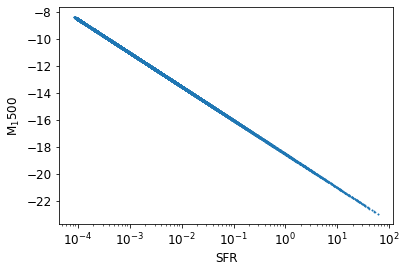

In [124]:
#eliminating halos without SF
ind_nice = np.where(np.logical_or(Mass_stel==0, SFR==0), False, True)
ind_sfr = np.where(SFR>0)

L_lya   = L_lya[ind_sfr]
Pos_Mpc = Pos_Mpc[ind_sfr]
Mass_stel = Mass_stel[ind_sfr]
SFR     = SFR[ind_sfr]
Mass_dm = Mass_dm[ind_sfr]

#L_UV starting from Madau Dickinson review
c = const.c.value*10**2 #[cm/s]
pc = const.pc.value*10**2 #[cm]
lambda_ang = 1500 #[A]
lambda_cm = 1500*10**(-8) #[cm]
val_Kenn = 1.4*10**(-28) #for Salpeter IMF
val_Chabr = val_Kenn*0.63 #for Chabrier IMF

#L_nu = SFR/val_Kenn
L_nu = SFR/val_Chabr
L_1500 = L_nu*c/(lambda_ang*lambda_cm)

#L_1500 = SFR*1.4*10**40
#L_nu = L_1500*lambda_ang*lambda_cm/c
#L_nu = np.array(L_nu).astype(np.float)
M_1500 = -2.5*np.log10(L_nu/(4*np.pi*(10*pc)**2))-48.6 

print('To copare with Garel 2015')
print(np.max(SFR[SFR<0.08]), np.min(M_1500[SFR<0.08]))
print(np.max(SFR[SFR<0.8]), np.min(M_1500[SFR<0.8]))
print(np.max(SFR[SFR<8]), np.min(M_1500[SFR<8]))

plt.scatter(SFR, M_1500, s=0.5)
plt.xscale('log')
plt.xlabel('SFR')
plt.ylabel(r'M$_1500$')

print(np.max(SFR))

## select the function

[1.36197289e-19 2.32558903e-20 3.86933533e-21 ... 3.42253888e-10
 2.91142620e-10 2.46832416e-10]


Text(0.5, 1.0, 'pdf(f|SFR = 1)')

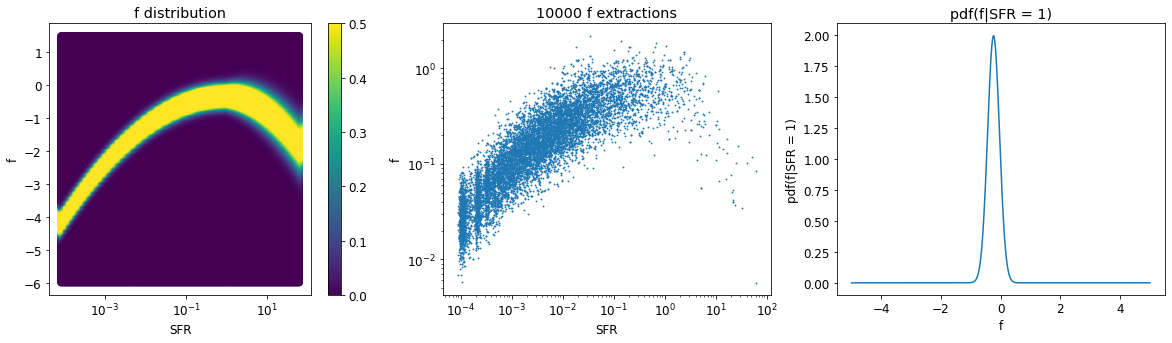

In [125]:
from scipy.stats import norm, uniform
from scipy.integrate import quad
from progress.bar import Bar

#0 = only arctan
#1 = arctan + gaus at 0
#2 = gaus with sigma=rarctan
#3 = 2nd degree pol
#4 = gaus with a 2nd degree poly as a sigma
select = 5


SFR_log = np.log10(SFR)
sfr_min = np.min(SFR_log)#10**(-2)
sfr_max = np.max(SFR_log)
delta=sfr_max-sfr_min
f = np.zeros(len(L_lya))

x_linsp = np.linspace(-5,5, 1000)
a=4


def gaus2(x,c, mean_0, sigma_0, mean_1, sigma_1):
    fun = c*norm.pdf(x,mean_0,sigma_0)+norm.pdf(x, mean_1, sigma_1)
    return fun

def zero_to_pi(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)*np.pi/2

def zero_to_one(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)

def f_dist(sfr,xx, sfr_min,sfr_max, c):
    x_var = zero_to_pi(sfr, sfr_min, sfr_max)  
    
    if select==0:
        mean_1 = np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 1000
        fun = gaus2(xx,0,mean_0,sigma_0, mean_1, sigma_1)
        
    if select==1:
        mean_1 = 1.5*np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 0.7*mean_1+0.01
        fun = gaus2(xx,c,mean_0,sigma_0, mean_1, sigma_1)
    
    if select==2:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        sigma_g = 0.36*norm.pdf(x_var, zero_to_one(0.37, sfr_min, sfr_max), 0.18)
        fun = norm.pdf(xx,0, sigma_g)
    
    if select==3:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = -x_var**2+1
        sigma_1 = 0.2*mean_1+0.03
        fun = norm.pdf(xx, mean_1, sigma_1)
        
    if select==4:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = 0.
        sigma_1 =(-x_var**2+1)+0.0001
        fun = norm.pdf(xx, mean_1, sigma_1)
    
    if select==5:
        sfr_max = np.log10(148.01710510253906)
        x_var1 = zero_to_one(sfr, -0.0, sfr_max)
        slope_sigma = 0.35
        int_sigma = 0.2
        mean_1 = np.where(x_var1<0, -1.1*x_var1**2, -2.2*x_var1**2)-0.24 
        sigma_1 = np.where(x_var1<-0, int_sigma, slope_sigma*x_var1+int_sigma)
        fun = norm.pdf(xx, mean_1,sigma_1)
    return fun

#if using the 2nd degree polynomial function this takes less time
def f_esc5(sfr):
    sfr_max = np.log10(148.01710510253906)
    x_var1 = zero_to_one(sfr, -0.0, sfr_max)
    x_var1 = zero_to_one(sfr, -0.0, sfr_max)
    slope_sigma = 0.18
    int_sigma = 0.2
    mean_1 = np.where(x_var1<0, -0.4*x_var1**2, -2.1*x_var1**2)-0.24 #-1,-2.1  #-0.4, -1.4   best; #-0.4, -1.8/1.6
    sigma_1 = np.where(x_var1<-0, int_sigma, slope_sigma*x_var1+int_sigma)
    return norm.rvs(mean_1, sigma_1)

min_ext= -6
max_ext = 1.5
if select==1:
    max_ext=4
if select==2:
    max_ext=4
if select==4:
    max_ext=5.5


fig,ax = plt.subplots(1,3, figsize=(20,5))
aa = np.logspace(sfr_min,sfr_max, 300)
bb = np.linspace(min_ext,max_ext, 300)
AA, BB = np.meshgrid(aa,bb)
AA = AA.reshape(-1)
BB = BB.reshape(-1)
color = f_dist(AA,BB,sfr_min,sfr_max,a)
print(color)
max_color = np.nanmax(f_dist(AA,BB,sfr_min,sfr_max,a))
pl =ax[0].scatter(AA,BB, c=color, vmin=0, vmax=0.5)
plt.colorbar(pl, ax = ax[0])
rand_x = np.random.uniform(min_ext,max_ext,len(SFR_log))
rand_y = np.random.uniform(0, max_color+0.0001, len(SFR_log))
ind_change = np.where(rand_y>f_dist(SFR, rand_x, sfr_min, sfr_max,a))

rand_x = f_esc5(SFR)
 
f = 10**rand_x
ind_change = np.where(np.logical_and(10**(-1.7)<SFR, 10**(-1)>SFR))
#f[ind_change] = np.random.uniform(1,2, len(ind_change[0]))


#plt.scatter(SFR, f)
ax[0].set_xscale('log')
ax[0].set_xlabel('SFR')
ax[0].set_ylabel('f')
ax[0].set_title('f distribution')

rand_indd = np.random.randint(0,len(L_lya), size=10000)
ax[1].scatter(SFR[rand_indd], f[rand_indd], s=0.7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('SFR')
ax[1].set_ylabel('f')
ax[1].set_title('10000 f extractions')


ax[2].plot(x_linsp, f_dist(1, x_linsp, sfr_min, sfr_max, a))
ax[2].set_xlabel('f')
ax[2].set_ylabel('pdf(f|SFR = 1)')
ax[2].set_title('pdf(f|SFR = 1)')


#da SFR -1.5 a -0.5

Text(1, 1.3, '10 M$_\\odot$ yr$^{-1}$')

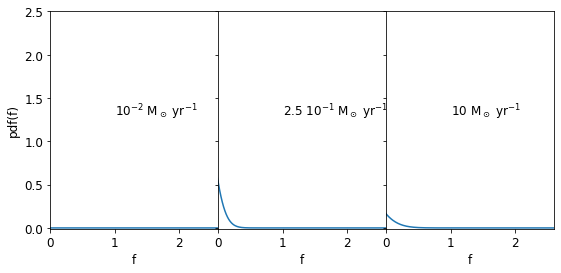

In [126]:
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(nrows=1, ncols=3, left=0.05, right=0.75,
                      hspace=0., wspace=0.0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

ax0.plot(x_linsp, f_dist(0.01, x_linsp, sfr_min, sfr_max, a))

ax0.set_xlabel('f')
ax0.set_ylabel('pdf(f)')
ax0.set_xlim(0,2.6)
ax0.text(1, 1.3,'10$^{-2}$ M$_\odot$ yr$^{-1}$')
ax0.set_ylim(-0.01,2.5)

ax1.plot(x_linsp, f_dist(2.5e-1, x_linsp, sfr_min, sfr_max, a))
ax1.set_xlabel('f')
ax1.set_xlim(0,2.6)
ax1.set_ylim(-0.01,2.5)
ax1.text(1, 1.3,'2.5 10$^{-1}$ M$_\odot$ yr$^{-1}$')
ax1.tick_params(labelleft=None)

ax2.plot(x_linsp, f_dist(10, x_linsp, sfr_min, sfr_max, a))
ax2.set_xlabel('f')
ax2.set_xlim(0,2.6)
ax2.set_ylim(-0.01,2.5)
ax2.tick_params(labelleft=None)
ax2.text(1, 1.3,'10 M$_\odot$ yr$^{-1}$')


Text(0.5, 1.0, 'Ly$\\alpha$ luminosity distribution applying f$_{\\rm esc}$')

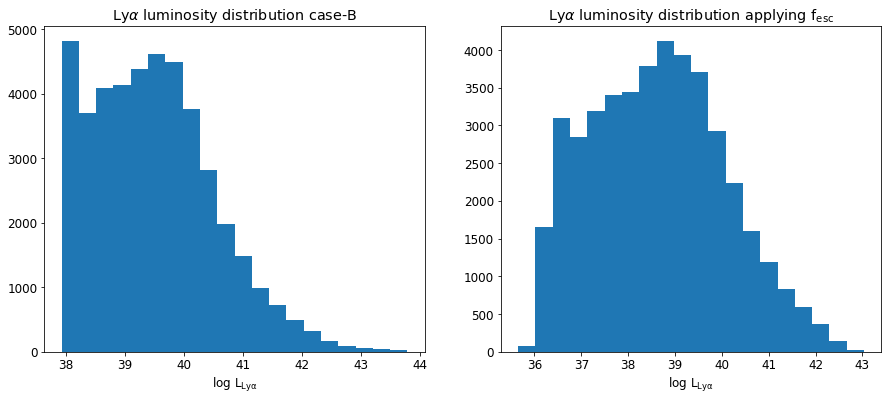

In [127]:
L_lya_obs = L_lya*f

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].hist(np.log10(L_lya), bins=20)
ax[1].hist(np.log10(L_lya_obs[L_lya_obs!=0]), bins=20)

for i in ax:
    i.set_xlabel(r'log L$_{\rm Ly\alpha}$')
ax[0].set_title(r'Ly$\alpha$ luminosity distribution case-B')
ax[1].set_title(r'Ly$\alpha$ luminosity distribution applying f$_{\rm esc}$')

In [128]:
from lum_func import *
from corr_functions import * 

if np.max(Pos_Mpc)>50:
    len_box=100
else:
    len_box=50
    
###LUMINOSITY FUNCTION
av_bin, counts, err_int = Lya_lumfunction(L_lya, 20, len_box) #the original case B
av_bin_obs, counts_obs, err_obs = Lya_lumfunction(L_lya_obs, 28, len_box) #the corrected one

###CORRELATION FUNCTION
N_boot = 1
bins = np.logspace(np.log10(0.1), np.log10(10), 15)
xi = np.zeros((N_boot, len(bins)-1))
xi_obs = np.zeros((N_boot, len(bins)-1))
#xi_int = np.zeros((N_boot, len(bins)-1))

for i in range(N_boot):
    bins_cen, xi[i], _ = corr_func(500, bins, Pos_Mpc, 0, len_box, False)
    bins_cen_ob, xi_obs[i], _ = corr_func(500, bins, Pos_Mpc[L_lya_obs>10**41.39], 0, len_box, False)
    #bins_cen_int, xi_int[i], _ = corr_func(500, bins, Pos_Mpc[np.logical_and(L_lya>10**41.39, L_lya<10**(42.87))], 0, 100, False)

med_xi = np.median(xi, axis=0)
sigma_xi = (np.percentile(xi, 75, axis=0) - np.percentile(xi, 25, axis=0))*0.7413

med_xi_obs = np.median(xi_obs, axis=0)
sigma_xi_obs = (np.percentile(xi_obs, 75, axis=0) - np.percentile(xi_obs, 25, axis=0))*0.7413

#med_xi_int = np.median(xi_int, axis=0)
#sigma_xi_int = (np.percentile(xi_int, 75, axis=0) - np.percentile(xi_int, 25, axis=0))*0.7413

###EW
EW = L_lya_obs/L_1500*(1500/1216)**(-1.5)

###EW fraction to compare with Kusakabe
Kusakabe_bins = np.array([-21.5, -20, -19, -18, -17])
Kusakabe_bins_cen = (Kusakabe_bins[1:]+Kusakabe_bins[:-1])/2

#dividing galaxies in bins of M_1500
ind_bins = [[] for i in range(len(Kusakabe_bins_cen))]
for i in range(len(Kusakabe_bins)-1):
    ind_bins[i] = np.where(np.logical_and(M_1500>=Kusakabe_bins[i], M_1500<Kusakabe_bins[i+1]))
    
#dividing galaxies in bins of EW
EW_thresh = [25,45,65,85]
EW_fraction = np.zeros([len(Kusakabe_bins_cen), len(EW_thresh)])
for j in range(len(Kusakabe_bins_cen)):
    for i in range(len(EW_thresh)):
        EW_fraction[j,i] = len(np.where(EW[ind_bins[j]]>EW_thresh[i])[0])/len(ind_bins[j][0])


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[3.5 1.6] [[inf inf]
 [inf inf]]


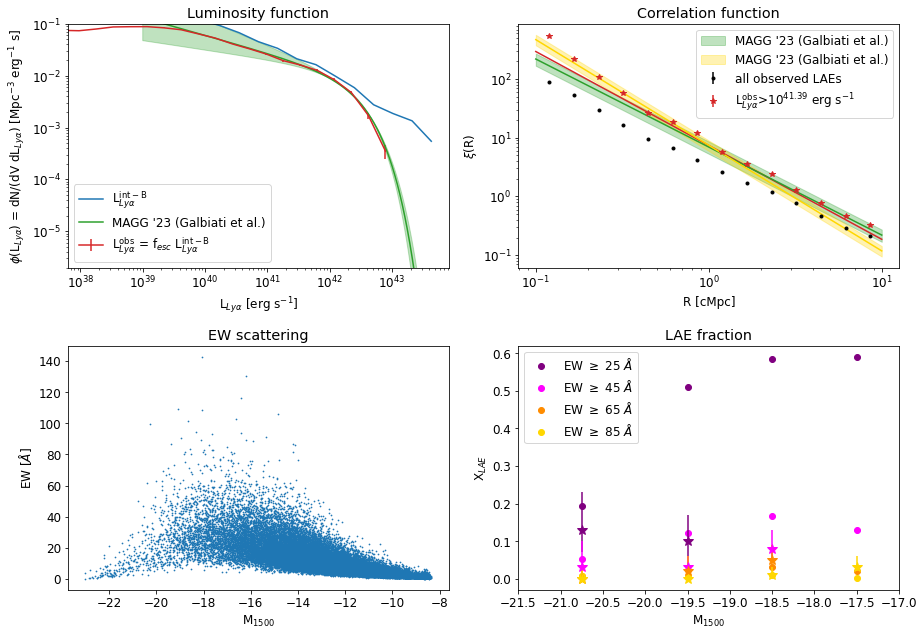

In [129]:
fig, ax = plt.subplots(2,2, figsize=(13,9))
ax=ax.reshape(-1)

##LF
ax[0].plot(av_bin, counts, label=r'L$_{Ly\alpha}^{\mathrm{int-B}}$ ')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Luminosity function')
ax[0].set_ylim(2*10**(-6), 10**(-1))
ax[0].set_xlim()
ax[0].set_xlabel(r'L$_{Ly\alpha}$ [erg s$^{-1}$]')
ax[0].set_ylabel(r'$\phi$(L$_{Ly\alpha}$) = dN/(dV dL$_{Ly\alpha}$) [Mpc$^{-3}$ erg$^{-1}$ s]')

#mackenzie_raw
mack_lf = np.genfromtxt('Mackenzie.txt')
#ax[0].plot(mack_lf[:,0], mack_lf[:,1],label='Mackenzie_raw')

#MAGG LF
def lum_fun(L, phi_star, alpha, L_star):
    return np.log(10)*phi_star*10**((L-L_star)*(alpha +1))*np.exp(-10**(L-L_star))

#from MAGG (the last one is the one I should use, the others are valid for selected samples)
alpha = [-1.164,-1.350,-1.418,-1.339]
L_star = [42.573, 42.558, 42.575, 42.466]
phi_star = [10**(-1.429), 10**(-1.788), 10**(-2.175), 10**(-2.422)]

err_par = [10**(0.121), 0.158, 0.08] #err_phi, err_alpha, err_logL_star

x_logsp = np.logspace(39, 44, 500)

magg = lum_fun(np.log10(x_logsp), phi_star[-1], alpha[-1], L_star[-1])
magg_1s_min = lum_fun(np.log10(x_logsp), phi_star[-1]/err_par[0], alpha[-1]-err_par[1], L_star[-1]+err_par[2])
magg_1s_max = lum_fun(np.log10(x_logsp), phi_star[-1]*err_par[0], alpha[-1]+err_par[1], L_star[-1]-err_par[2])
ax[0].plot((x_logsp), (magg), label="MAGG '23 (Galbiati et al.)", c='tab:green')
ax[0].fill_between((x_logsp), (magg_1s_min), (magg_1s_max), color='tab:green', alpha=0.3)

#with f_esc
ax[0].errorbar(av_bin_obs, counts_obs, yerr=err_obs, c='tab:red', label=r'L$_{Ly\alpha}^{\mathrm{obs}}$ = f$_{esc}$ L$_{Ly\alpha}^{\mathrm{int-B}}$') 

ax[0].legend()

##CORRELATION
ax[1].errorbar(bins_cen, med_xi, sigma_xi, fmt='.k', label=r'all observed LAEs')
ax[1].errorbar(bins_cen_ob, med_xi_obs, sigma_xi_obs, color='tab:red', ls='', marker='*', label=r'L$_{Ly\alpha}^{\mathrm{obs}}$>10$^{41.39}$ erg s$^{-1}$')
#ax[1].errorbar(bins_cen_int, med_xi_int, sigma_xi_int, color='tab:blue', marker = 's', label=r'L$_{Ly\alpha}^{\mathrm{int}}$>10$^{41.39}$ erg s$^{-1}$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('R [cMpc]')
ax[1].set_ylabel(r'$\xi$(R)')
ax[1].set_title('Correlation function')
x_log = np.logspace(-1,1,100)

from scipy.optimize import curve_fit
def powercorr(x, r0, gamma):
    return (r0/x)**(gamma)
popt, pcov = curve_fit(powercorr, bins_cen_ob, med_xi_obs, p0=[3.5, 1.6], sigma=sigma_xi_obs)
ax[1].plot(x_log, powercorr(x_log, popt[0], popt[1]), color='tab:red')
ax[1].fill_between(x_log, powercorr(x_log, popt[0]+np.sqrt(pcov[0,0]), popt[1]-np.sqrt(pcov[1,1])), 
                  powercorr(x_log, popt[0]-np.sqrt(pcov[0,0]), popt[1]+np.sqrt(pcov[1,1])), color='tab:red', alpha=0.3)
print(popt, np.sqrt(pcov))
#print(2.30/0.6777)

#ax[1].plot(x_log, (x_log/2.95)**(-1.47), label='from LF calibration')
ax[1].plot(x_log, (x_log*0.6777/2.47)**(-1.5), color='tab:green')
ax[1].fill_between(x_log, (x_log*0.6777/2.07)**(-1.5), (x_log*0.6777/2.85)**(-1.5), color='tab:green', 
                   alpha=0.3, label="MAGG '23 (Galbiati et al.)")
ax[1].plot(x_log, (x_log*0.6777/2.07)**(-1.8), color='gold')
ax[1].fill_between(x_log, (x_log*0.6777/2.30)**(-1.8), (x_log*0.6777/1.83)**(-1.8), color='gold', 
                   alpha=0.3, label="MAGG '23 (Galbiati et al.)")
ax[1].legend()
#add Herrero alonso from magg paper

##EW scatter
ax[2].scatter(M_1500, EW, s=0.5)
ax[2].set_xlabel(r'M$_{1500}$')
ax[2].set_ylabel(r'EW [$\AA$]')
ax[2].set_title('EW scattering')
#ax[2].set_xscale('log')
#ax[2].set_xlim(-10,-24)
#ax[2].set_ylim(0,90)

##LAE fraction
Kusak_res_25 = [0.13, 0.10]
Kusak_res_25_err = [[0.06,0.04], [0.1, 0.07]]
Kusak_res_45 = [0.03, 0.03, 0.08]
Kusak_res_45_err = [[0.02, 0.02, 0.03],[0.07, 0.03, 0.05]]
Kusak_res_65 = [0.00, 0.02, 0.05]
Kusak_res_65_err = [[0.00, 0.01, 0.02],[0.03,0.04, 0.04]]
Kusak_res_85 = [0.00, 0.00, 0.01, 0.03]
Kusak_res_85_err = [[0.00,0.00,0.00,0.01], [0.03, 0.02, 0.02, 0.03]]

Kusak_res = [Kusak_res_25, Kusak_res_45, Kusak_res_65, Kusak_res_85]
Kusak_err = [Kusak_res_25_err, Kusak_res_45_err, Kusak_res_65_err, Kusak_res_85_err]

color_list = ['purple', 'magenta', 'darkorange', 'gold']
for i in range(4):
    ax[3].errorbar(Kusakabe_bins_cen[:len(Kusak_res[i])], Kusak_res[i], yerr=Kusak_err[i], marker='*', markersize=10, ls='', color=color_list[i])
    ax[3].scatter(Kusakabe_bins_cen, EW_fraction[:,i], label=r'EW $\geq$ %i $\AA$' %EW_thresh[i], color=color_list[i])
ax[3].set_xlim(-21.5, -17)
ax[3].set_xlabel(r'M$_{1500}$')
ax[3].set_ylabel(r'X$_{LAE}$')
ax[3].set_title('LAE fraction')
ax[3].legend()
#ax[3].set_ylim(0,0.3)
fig.tight_layout()


46.9177233852744


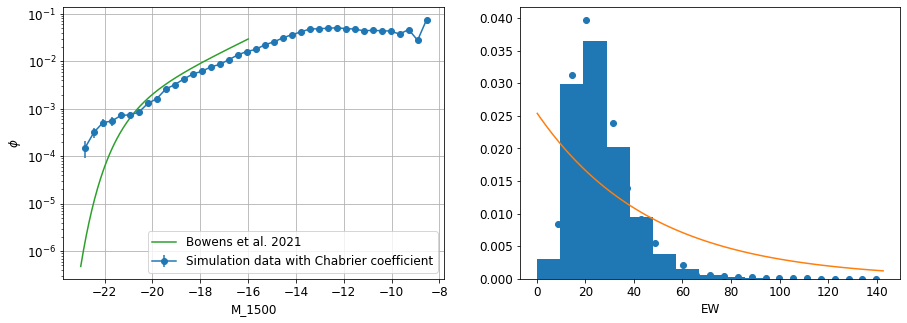

In [130]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
from lum_func import *

av_bin_1500, counts_1500, err_1500 = lum_func_mag(M_1500, 40, len_box)
ax[0].errorbar(av_bin_1500, counts_1500, yerr=err_1500, marker='o', label='Simulation data with Chabrier coefficient')
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('M_1500')
ax[0].set_ylabel(r'$\phi$')

#From Bowens 2021 UV lum function at z about 3
def schechter_fun(M, phi_star, alpha, M_star):
    return phi_star*np.log(10)/2.5*10**((M_star-M)*(alpha +1)/2.5)*np.exp(-10**((M_star-M)/2.5))
Bow_par = [2.1*10**(-3), -1.61, -20.87]
mag_space = np.linspace(-23, -16, 300)
ax[0].plot(mag_space, schechter_fun(mag_space, Bow_par[0], Bow_par[1], Bow_par[2]), color='tab:green', label='Bowens et al. 2021')
ax[0].legend()
ax[0].grid()
#ax[0].set(xticks= [10**(-23), 10**(-21), 10**(-19), 10**(-17), 10**(-15), 10**(-13), 10**(-11)],
                    # xticklabels= ['-23', '-21', '-19', '-17', '-15', '-13', '-11'])
    
counts_ew, bins_ew = np.histogram(EW[L_lya_obs>10**40], bins=25, density=True)
bins_cen_ew = (bins_ew[1:]+bins_ew[:-1])/2
ax[1].hist(EW[L_lya_obs>10**40], bins=15, density=True)
ax[1].scatter(bins_cen_ew, counts_ew)
def exponential(x, w0, N):
    return N*np.exp(-x/w0)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential, bins_cen_ew[:], counts_ew[:], p0=[95, 40000]) 
ew_lin = np.linspace(np.min(EW), np.max(EW), 100)
ax[1].plot(ew_lin, exponential(ew_lin, popt[0], popt[1]))
ax[1].set_xlabel('EW')
print(popt[0])

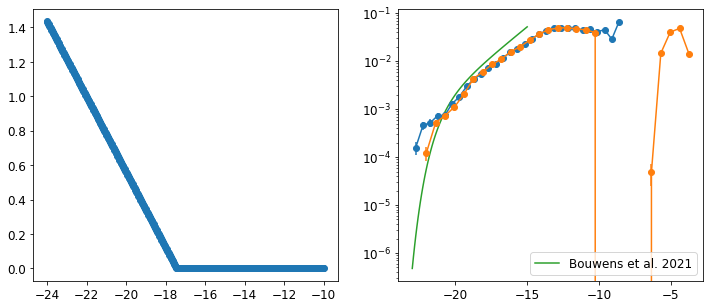

In [139]:
#700 bins of observed UV luminosity
M_uv_linsp = np.linspace(-24, -10, 700)

#mean beta for each bin
def beta_m(M_uv):
    return -0.11*(M_uv + 19.5) - 2

#Afuv mean for each bin
beta_bins = beta_m(M_uv_linsp)
Afuv_1 = 4.43+1.99*beta_bins
Afuv_1 = np.where(Afuv_1<=0, 0, Afuv_1)

#the intrinsic u magnitude in each bin
M_uv_int = M_uv_linsp - Afuv_1

#defining magnitude bins
M_uv_int_bins = (M_uv_int[1:]+M_uv_int[:-1])/2
M_uv_int_bins = np.insert(M_uv_int_bins, 0, np.min(M_1500))

beta_mean = np.zeros(len(M_1500))
#beta_std = np.zeros(len(M_1500))

for i in range(len(M_1500)):
    for j in range(len(M_uv_int_bins)-1):
        if M_1500[i]>M_uv_int_bins[j] and M_1500[i]<M_uv_int_bins[j+1]:
            beta_mean[i] = beta_bins[j]
            #beta_std[i] = beta_sigma[j]
            
beta_uv = np.random.normal(beta_mean, 0.1)
true_A_uv = 4.43+1.99*beta_uv
true_A_uv = np.where(true_A_uv<0, 0, true_A_uv)

M_1500_obs = M_1500 + true_A_uv
av_bin_1500, counts_1500, err_1500 = lum_func_mag(M_1500, 30, len_box)
av_bin_1500_obs, counts_1500_obs, err_1500_obs = lum_func_mag(M_1500_obs, 30, len_box)
 
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].scatter(M_uv_linsp, Afuv_1)
ax[1].errorbar(av_bin_1500, counts_1500, yerr=err_1500, marker='o')
ax[1].errorbar(av_bin_1500_obs, counts_1500_obs, yerr=err_1500_obs, marker='o')
ax[1].set_yscale('log')

ax[1].plot(mag_space, schechter_fun(mag_space, Bow_par[0], Bow_par[1], Bow_par[2]), color='tab:green', label='Bouwens et al. 2021')
ax[1].legend()


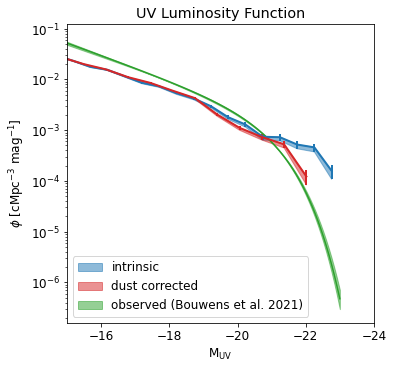

In [140]:
fig, ax = plt.subplots(1,1, figsize=(5.5, 5.5))

Bow_par = [2.1*10**(-3), -1.61, -20.87]
Bow_err = [0.3*10**(-3), 0.03, 0.09]

ax.errorbar(av_bin_1500, counts_1500, yerr=err_1500, lw=2)
ax.fill_between(av_bin_1500, counts_1500, counts_1500 - err_1500, counts_1500+err_1500, color='tab:blue', alpha=0.5, label='intrinsic')
ax.errorbar(av_bin_1500_obs, counts_1500_obs, yerr=err_1500_obs, lw=2, c='tab:red')
ax.fill_between(av_bin_1500_obs, counts_1500_obs, counts_1500_obs - err_1500_obs, counts_1500_obs+err_1500_obs, color='tab:red', alpha=0.5, label='dust corrected')


ax.set_yscale('log')
ax.set_xlim(-15, -24)
mag_space=np.linspace(-23, -15, 100)
Bouwens_fun = schechter_fun(mag_space, Bow_par[0], Bow_par[1], Bow_par[2])
Bouwens_fun_1s = schechter_fun(mag_space, Bow_par[0]+Bow_err[0], Bow_par[1]+Bow_err[1], Bow_par[2]+Bow_err[2])
Bouwens_fun_1S = schechter_fun(mag_space, Bow_par[0]-Bow_err[0], Bow_par[1]-Bow_err[1], Bow_par[2]-Bow_err[2])
ax.plot(mag_space, Bouwens_fun, color='tab:green' )
ax.fill_between(mag_space, Bouwens_fun_1s, Bouwens_fun_1S, color='tab:green', alpha=0.5, label='observed (Bouwens et al. 2021)')
ax.legend()
ax.set_xlabel(r'M$_{\rm UV}$')
ax.set_ylabel(r'$\phi$ [cMpc$^{-3}$ mag$^{-1}$]')
ax.set_title('UV Luminosity Function')

plt.savefig('UVlumfun.pdf',  bbox_inches="tight")

Text(0, 0.5, '$\\beta_{\\rm UV}$')

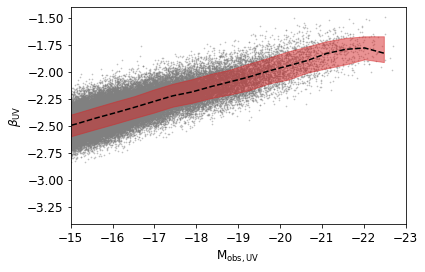

In [105]:
plt.scatter(M_1500_obs, beta_uv, c ='grey', alpha=0.4, s=0.5)
mag_space = np.linspace(np.min(M_1500_obs), -14, 20)
bin_cen_ms = (mag_space[1:]+mag_space[:-1])/2

beta_perc = np.zeros((len(mag_space)-1, 3))
per = [16,50,84]

for i in range(len(mag_space)-1):
    for j in range(len(per)):
        beta_perc[i,j] = np.percentile(beta_uv[np.logical_and(M_1500_obs<mag_space[i+1], M_1500_obs>mag_space[i])], per[j])
        
plt.plot(bin_cen_ms, beta_perc[:,1], ls='--', color='black')
plt.fill_between(bin_cen_ms, beta_perc[:,0], beta_perc[:,2], color='tab:red', alpha=0.5)
plt.xlim(-15, -23)
plt.xlabel(r'M$_{\rm obs, UV}$')
plt.ylabel(r'$\beta_{\rm UV}$')

4.403778473494512e+41
9.280333308917524e+41


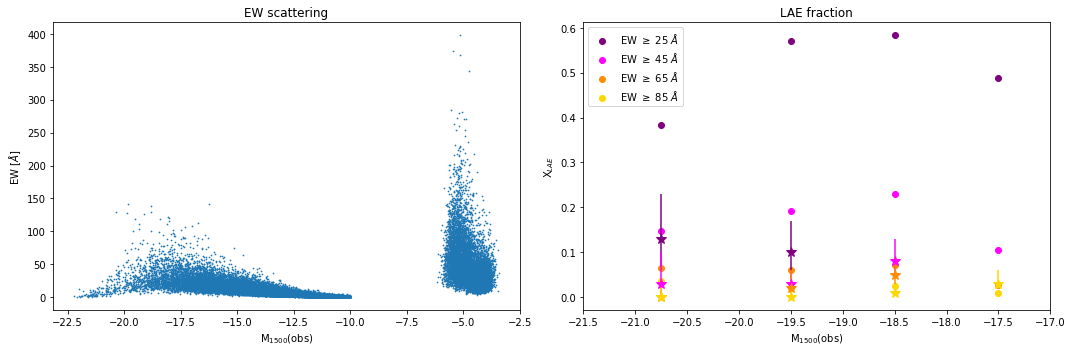

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

L_1500_obs_nu = 4*np.pi*(10*pc)**2* 10**(-(M_1500_obs+48.6)/2.5)
L_1500_obs = L_1500_obs_nu*(c/(1500**2*10**(-8)))

print(np.max(L_1500_obs))
print(np.max(L_1500))

##EW scatter
EW_obs = EW = L_lya_obs/L_1500_obs*(1500/1216)**(beta_uv)

ax[0].scatter(M_1500_obs, EW_obs, s=0.5)
ax[0].set_xlabel(r'M$_{1500}$(obs)')
ax[0].set_ylabel(r'EW [$\AA$]')
ax[0].set_title('EW scattering')
#ax[2].set_xscale('log')
#ax[2].set_xlim(-10,-24)
#ax[2].set_ylim(0,90)

##LAE fraction
EW_fraction_obs = np.zeros([len(Kusakabe_bins_cen), len(EW_thresh)])
for j in range(len(Kusakabe_bins_cen)):
    for i in range(len(EW_thresh)):
        EW_fraction_obs[j,i] = len(np.where(EW_obs[ind_bins[j]]>EW_thresh[i])[0])/len(ind_bins[j][0])

color_list = ['purple', 'magenta', 'darkorange', 'gold']
for i in range(4):
    ax[1].errorbar(Kusakabe_bins_cen[:len(Kusak_res[i])], Kusak_res[i], yerr=Kusak_err[i], marker='*', markersize=10, ls='', color=color_list[i])
    ax[1].scatter(Kusakabe_bins_cen, EW_fraction_obs[:,i], label=r'EW $\geq$ %i $\AA$' %EW_thresh[i], color=color_list[i])
ax[1].set_xlim(-21.5, -17)
ax[1].set_xlabel(r'M$_{1500}$(obs)')
ax[1].set_ylabel(r'X$_{LAE}$')
ax[1].set_title('LAE fraction')
ax[1].legend()
#ax[1].set_ylim(0,0.3)
fig.tight_layout()

(1000000000, 100000000000000)

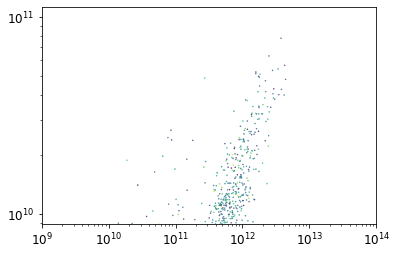

In [34]:
plt.scatter(Mass_dm[L_lya_obs>10**41.39], Mass_stel[L_lya_obs>10**41.39], c=np.log10(L_lya_obs[L_lya_obs>10**41.39]), s=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**9, 10**14)

(array([ 120.,   83.,   41.,   16.,   14.,   10.,   12.,   60.,  105.,
         266.,  370.,  621., 1408., 3128., 2753., 1349.,  564.,  208.,
          76.,   20.]),
 array([ 6.81758738,  7.10886806,  7.40014875,  7.69142943,  7.98271012,
         8.2739908 ,  8.56527148,  8.85655217,  9.14783285,  9.43911353,
         9.73039422, 10.0216749 , 10.31295558, 10.60423627, 10.89551695,
        11.18679763, 11.47807832, 11.769359  , 12.06063969, 12.35192037,
        12.64320105]),
 <BarContainer object of 20 artists>)

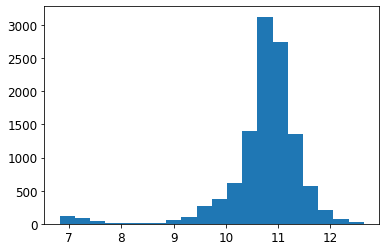

In [35]:
plt.hist(np.log10(Mass_dm[np.logical_and(Mass_dm!=0, L_lya_obs>10**41.39)]), bins=20)

(array([ 1.,  0.,  0.,  0.,  2.,  1.,  3., 26., 90., 21.]),
 array([36.44534909, 37.1024698 , 37.75959052, 38.41671123, 39.07383195,
        39.73095266, 40.38807338, 41.04519409, 41.7023148 , 42.35943552,
        43.01655623]),
 <BarContainer object of 10 artists>)

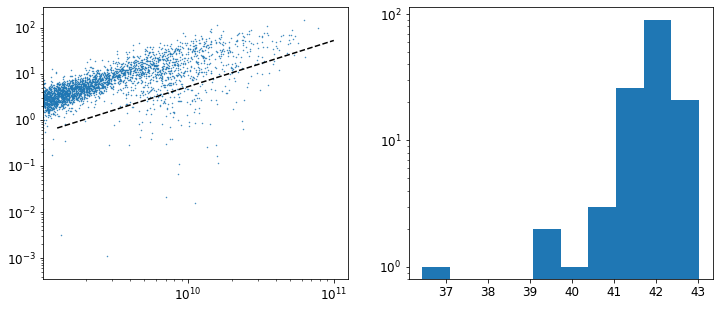

In [51]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].scatter(Mass_stel, SFR, s=0.2)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
m_linspace = np.logspace(9.1, 11, 50)
ax[0].plot(m_linspace, m_linspace/(1.9*10**9), ls='--', color='black')
quiet_g = np.where(np.logical_and(SFR<Mass_stel/(1.9*10**9), Mass_stel>2e9))
ax[1].set_yscale('log')
ax[1].hist(np.log10(L_lya_obs[quiet_g]))


## Oyarzun comparison

7.261134618639625e+41


Text(0.5, 0, 'log Stellar Mass')

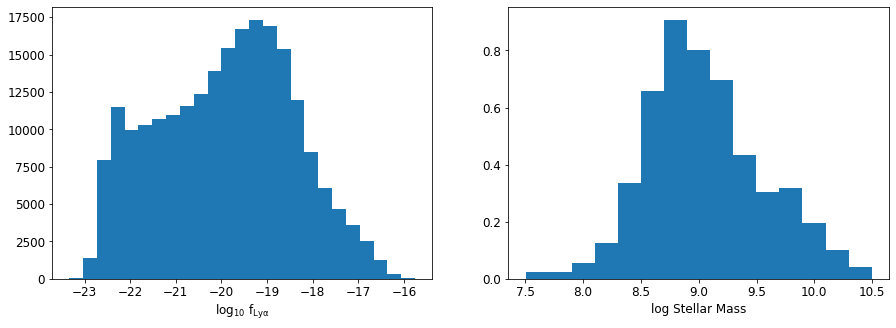

In [50]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307)

z_sim = 3.0165046357126
flux_lya = L_lya_obs/(4*np.pi*(cosmo.luminosity_distance(z_sim).value*10**6*pc)**2)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(np.log10(flux_lya), bins=25)
ax[0].set_xlabel(r'log$_{10}$ f$_{\rm Ly\alpha}$')
ind_flux_lim = np.where(np.logical_and(flux_lya>8*5.5/5*10**(-18), (np.logical_and(Mass_stel>10**7.5, Mass_stel<10**10.5))))
flux_lya_det = flux_lya[ind_flux_lim]
Mass_stel_f = Mass_stel[ind_flux_lim]
SFR_f = SFR[ind_flux_lim]
f_f =4.4/8.7* f[ind_flux_lim]
EW_f = EW_obs[ind_flux_lim]
print(np.min(L_lya_obs[ind_flux_lim]))
ax[1].hist(np.log10(Mass_stel_f), bins=15, density=True)

ax[1].set_xlabel('log Stellar Mass')

4929
130
0.3670220136912887


Text(100, 0.035, 'w0 best : 28.20')

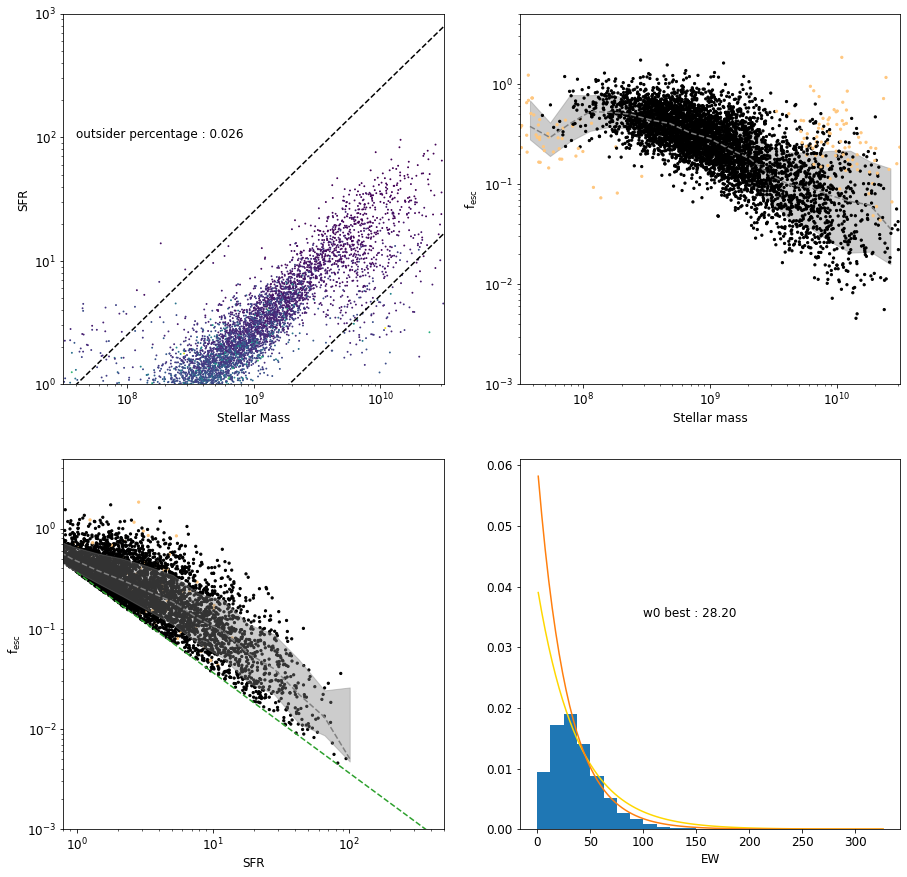

In [37]:
fig, ax = plt.subplots(2,2,figsize=(15,15))
ax = ax.reshape(-1)

ax[0].scatter(Mass_stel_f, SFR_f, c=f_f, s=0.8)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Stellar Mass')
ax[0].set_ylabel('SFR')
ax[0].set_xlim(10**(7.5), 10**(10.5))
ax[0].set_ylim(1, 1000)
m_linspace = np.logspace(7.5,10.5)
ax[0].plot(m_linspace, m_linspace/(40*10**6), ls='--', color='black')
ax[0].plot(m_linspace, m_linspace/(1.9*10**9), ls='--', color='black')

N_tot = len(Mass_stel_f)
print(N_tot)
ind_out = np.where(np.logical_or(SFR_f>Mass_stel_f/(40*10**6), SFR_f<Mass_stel_f/(1.9*10**9)))
N_out =len(ind_out[0])
print(N_out)
perc_out = N_out/N_tot
ax[0].text(10**(7.6), 100, 'outsider percentage : %.3f' %perc_out)

scat_color = np.where(np.logical_or(SFR_f>Mass_stel_f/(40*10**6), SFR_f<Mass_stel_f/(1.9*10**9)), 
                      1, 0)
mass_bins = np.logspace(7.5, 10.5, 20)

mass_bins_cen = 10**((np.log10(mass_bins[1:])+np.log10(mass_bins[:-1]))/2)
med_counts_mcomp = np.zeros(len(mass_bins)-1)
perc_16 = np.zeros(len(mass_bins)-1)
perc_84 = np.zeros(len(mass_bins)-1)

for i in range(len(mass_bins)-1):
    med_counts_mcomp[i] = np.median(f_f[np.where(np.logical_and(Mass_stel_f<mass_bins[i+1], Mass_stel_f>mass_bins[i]))])
    perc_16[i] =  np.percentile(f_f[np.where(np.logical_and(Mass_stel_f<mass_bins[i+1], Mass_stel_f>mass_bins[i]))], 16)
    perc_84[i] =  np.percentile(f_f[np.where(np.logical_and(Mass_stel_f<mass_bins[i+1], Mass_stel_f>mass_bins[i]))], 84)

ax[1].plot(mass_bins_cen, med_counts_mcomp, c='grey', ls='--')
ax[1].fill_between(mass_bins_cen, perc_16, perc_84, color='grey', alpha=0.4)
ax[1].scatter(Mass_stel_f, f_f, s=5, c=scat_color, cmap='copper')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('Stellar mass')
ax[1].set_ylabel(r'f$_{\rm esc}$')
ax[1].set_xlim(10**(7.5), 10**(10.5))
ax[1].set_ylim(10**(-3), 5)

ax[2].scatter(SFR_f, f_f, s=5, c=scat_color, cmap='copper')
sfr_bins = np.logspace(-0.5, 2.1, 15)
sfr_bins_cen = 10**((np.log10(sfr_bins[1:])+np.log10(sfr_bins[:-1]))/2)
med_counts_sfrcomp = np.zeros(len(sfr_bins)-1)
perc_16_sfr = np.zeros(len(sfr_bins)-1)
perc_84_sfr = np.zeros(len(sfr_bins)-1)

for i in range(len(sfr_bins)-1):
    med_counts_sfrcomp[i] = np.median(f_f[np.where(np.logical_and(SFR_f<sfr_bins[i+1], SFR_f>sfr_bins[i]))])
    perc_16_sfr[i] =  np.percentile(f_f[np.where(np.logical_and(SFR_f<sfr_bins[i+1], SFR_f>sfr_bins[i]))], 16)
    perc_84_sfr[i] =  np.percentile(f_f[np.where(np.logical_and(SFR_f<sfr_bins[i+1], SFR_f>sfr_bins[i]))], 84)

ax[2].plot(sfr_bins_cen, med_counts_sfrcomp, c='grey', ls='--')
ax[2].fill_between(sfr_bins_cen, perc_16_sfr, perc_84_sfr, color='grey', alpha=0.4)
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_xlabel('SFR')
ax[2].set_ylabel(r'f$_{\rm esc}$')
ax[2].set_xlim(0.8, 500)
ax[2].set_ylim(10**(-3), 5)
sfr_linsp = np.logspace(0,3, 100)
f_esc_min = 8*4.4/8.7*5.5/5*(10**(-18))*(4*np.pi*(cosmo.luminosity_distance(z_sim).value*pc*10**6)**2)/(10**42)
print(f_esc_min)
ax[2].plot(sfr_linsp, f_esc_min/sfr_linsp, c='tab:green', ls = '--')

par_or = [38, 0.04]
ew_bins = np.array([0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 
                    137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225])
ax[3].hist(EW_f, bins=ew_bins, density=True)
counts_ew, bins_ew = np.histogram(EW_f, bins=ew_bins, density=True)
bins_cen_ew = (bins_ew[1:]+bins_ew[:-1])/2

def exponential(x, w0, a):
    return a*np.exp(-x/w0)
def exponential_fixed(x,a):
    return a*np.exp(-x/38)

M_bins = np.array([8.2, 9, 9.3, 9.7, 11.4])
M_centre = (M_bins[1:]+M_bins[:-1])/2
f_esc_w = np.array([0.25, 0.13, 0.07, 0.05])

#ax[1].scatter(10**M_centre, f_esc_w)
from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential, bins_cen_ew[2:], counts_ew[2:], p0=[38, 2]) 
pfix, varfix = curve_fit(exponential_fixed, bins_cen_ew, counts_ew, p0=[0.04])

ew_lin = np.linspace(np.min(EW_f), np.max(EW_f), 100)
ax[3].plot(ew_lin, exponential(ew_lin, par_or[0], par_or[1]), c='gold', label='Oyarzun 2017')
ax[3].plot(ew_lin,exponential(ew_lin, popt[0], popt[1]), c='tab:orange')
ax[3].set_xlabel('EW')
ax[3].text(100, 0.035, 'w0 best : %.2f' %popt[0])

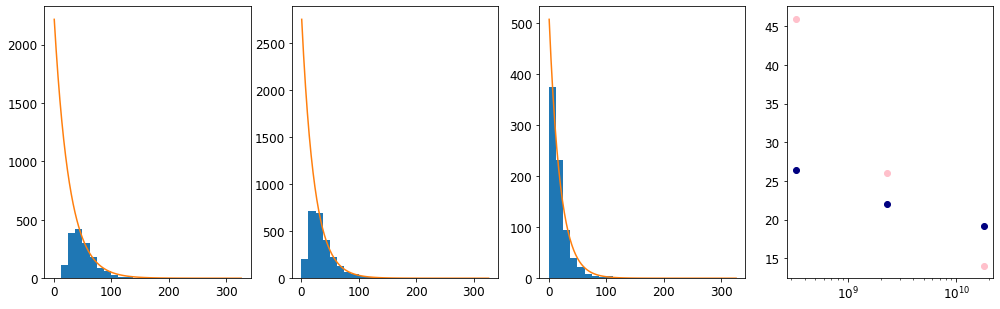

In [38]:
fig, ax = plt.subplots(1,4, figsize=(17,5))

mass_bins = np.array([10**7.5,10**8.8, 10**9.6, 10**10.5])
ew_bins = np.array([0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 
                    137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225])
ew_bins_cen = (ew_bins[1:]+ew_bins[:-1])/2
ew_linsp_f = np.linspace(np.min(EW_f), np.max(EW_f), 100)

counts_lm, bins_lm = np.histogram(EW_f[Mass_stel_f<mass_bins[1]], bins=ew_bins)
ax[0].hist(EW_f[Mass_stel_f<mass_bins[1]], bins=ew_bins)
p_lm, cov_lm = curve_fit(exponential, ew_bins_cen[3:], counts_lm[3:], p0=[38, 2]) 
ax[0].plot(ew_linsp_f, exponential(ew_linsp_f, p_lm[0], p_lm[1]), c='tab:orange')

counts_mm, bins_mm = np.histogram(EW_f[np.logical_and(Mass_stel_f<mass_bins[2], Mass_stel_f>mass_bins[1])], bins=ew_bins)
ax[1].hist(EW_f[np.logical_and(Mass_stel_f<mass_bins[2], Mass_stel_f>mass_bins[1])], bins=ew_bins)
p_mm, cov_mm = curve_fit(exponential, ew_bins_cen[2:], counts_mm[2:], p0=[38, 2]) 
ax[1].plot(ew_linsp_f, exponential(ew_linsp_f, p_mm[0], p_mm[1]), c='tab:orange')
           
counts_hm, bins_hm = np.histogram(EW_f[Mass_stel_f>mass_bins[2]], bins=ew_bins)
ax[2].hist(EW_f[Mass_stel_f>mass_bins[2]], bins=ew_bins)
p_hm, cov_hm = curve_fit(exponential, ew_bins_cen[:], counts_hm[:], p0=[38, 2])
ax[2].plot(ew_linsp_f, exponential(ew_linsp_f, p_hm[0], p_hm[1]), c='tab:orange')

ax[3].scatter((mass_bins[1:]+mass_bins[:-1])/2,[p_lm[0], p_mm[0], p_hm[0]], label='this work', c='navy')
ax[3].scatter((mass_bins[1:]+mass_bins[:-1])/2,[46,26,14], label='Oyarzun 2017', c='pink')
ax[3].set_xscale('log')

In [437]:
#Lya emitters losely associated with the absorbers
#HI



In [17]:
#SFR vs halo mass
#Lya lum vs halo mass

#Rahmati, eop

Text(0, 0.5, '$\\beta$')

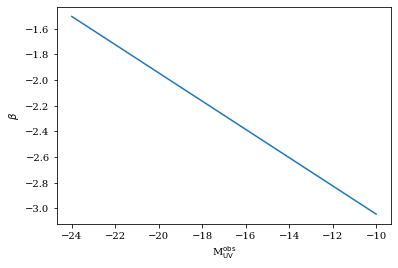

In [45]:
plt.plot(M_uv_linsp, beta_bins)
plt.xlabel(r'M$_{\rm UV}^{\rm obs}$')
plt.ylabel(r'$\beta$')

In [134]:
import dynesty

def f_esc5(sfr, par):
    x_var1 = zero_to_one(sfr, -0.0, sfr_max)
    slope_sigma = par[1]
    int_sigma = 0.34
    mean_1 = np.where(x_var1<0, -1.1*x_var1**2, par[0]*x_var1**2)-0.24
    sigma_1 = np.where(x_var1<-0, int_sigma, slope_sigma*x_var1+int_sigma)
    return norm.rvs(mean_1, sigma_1)

alpha = [-1.164,-1.350,-1.418,-1.339]
L_star = [42.573, 42.558, 42.575, 42.466]
phi_star = [10**(-1.429), 10**(-1.788), 10**(-2.175), 10**(-2.422)]
err_par = [10**(0.121), 0.158, 0.08] #err_phi, err_alpha, err_logL_star

def loglike(par):
    f_ext = f_esc5(SFR, par)
    L_lya_obs = (10**f_ext)*L_lya
    av_bin_obs, counts_obs, err_obs = Lya_lumfunction(L_lya_obs[L_lya_obs>10**40], 20)
    lumf_magg = lum_fun(np.log10(av_bin_obs), phi_star[-1], alpha[-1], L_star[-1])
    magg_1s_min = lum_fun(np.log10(av_bin_obs), phi_star[-1]/err_par[0], alpha[-1]-err_par[1], L_star[-1]+err_par[2])
    magg_1s_max = lum_fun(np.log10(av_bin_obs), phi_star[-1]*err_par[0], alpha[-1]+err_par[1], L_star[-1]-err_par[2])
    err = np.where(counts_obs>0, np.sqrt(counts_obs), 1)
    log_L = -0.5*np.sum((counts_obs - lumf_magg)**2)
    if not np.isfinite(log_L):
        return -np.inf  
    else:
        return log_L 
    
    return log_L

def ptform(u):
    par = np.array(u)
    par[0] = u[0]*100-60
    par[1] = u[1]
    return par


In [135]:
import warnings; warnings.simplefilter('ignore')
ndim=2
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=2000 )
sampler.run_nested()
sresults = sampler.results
sresults.summary()

289it [00:19, 15.15it/s, +2000 | bound: 0 | nc: 1 | ncall: 4319 | eff(%): 98.706 | loglstar:   -inf < -0.000 <    inf | logz: -0.001 +/-    nan | dlogz:  0.000 >  2.009]

Summary
nlive: 2000
niter: 289
ncall: 2319
eff(%): 98.706
logz: -0.001 +/-  0.002


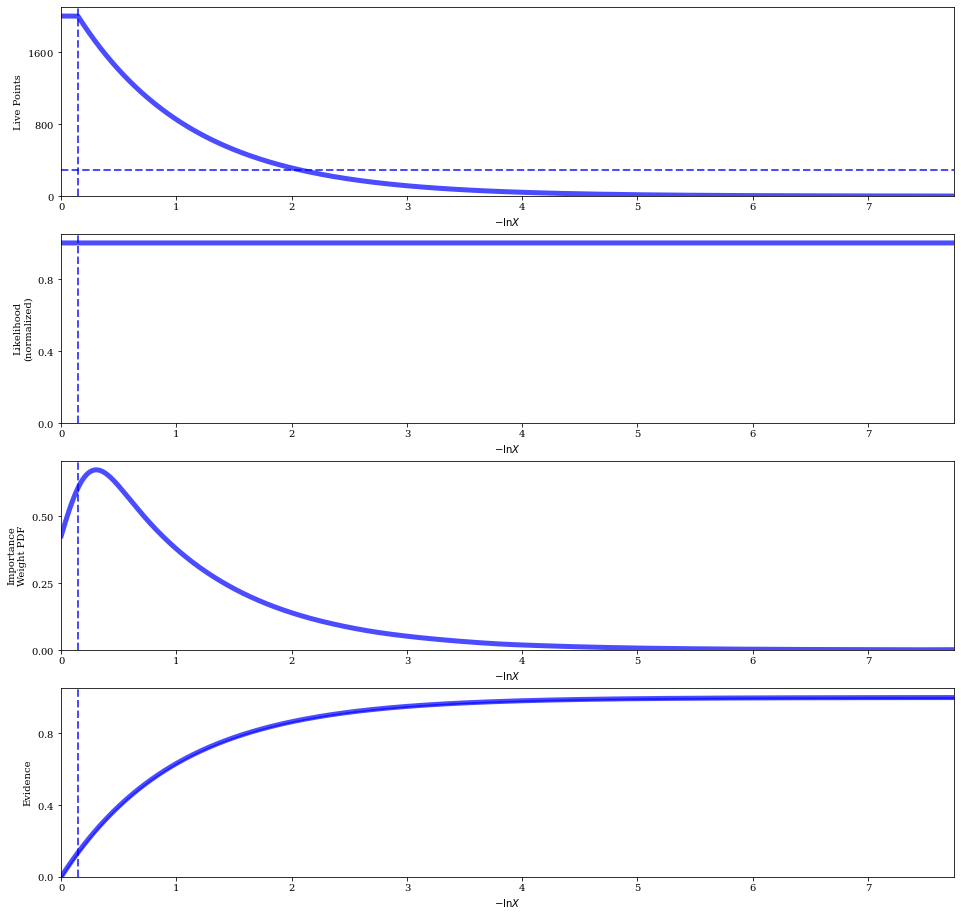

In [136]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

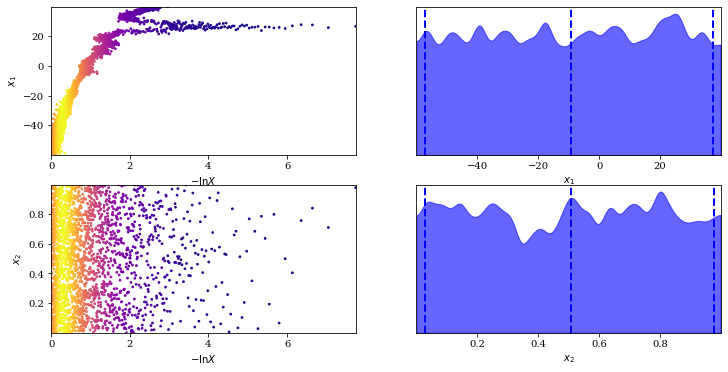

In [137]:
tfig, taxes = dyplot.traceplot(sresults)

In [138]:
from dynesty import utils as dyfunc

#Samples extracted
samples = sresults.samples 

#Normalized Weights = dZ/Ztot 
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Compute median and 1sigma intervals.
quantiles = [dyfunc.quantile(samps, [0.16, 0.50, 0.84], weights=weights)
             for samps in samples.T]
print('16-50-84 percentiles are: \nA : ', str(quantiles[0]), '\nb : ', str(quantiles[1]), '\nt0 : ', str(quantiles[2]), '\nalpha : ', str(quantiles[3]))

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('\nMean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

IndexError: list index out of range

In [ ]:
import corner
fig = corner.corner(samples_equal, levels=(0.68, 0.95), quantiles=(0.05, 0.5, 0.95), labels=[r'$A$', r'$b$', r'$t_{0}$', r'$\alpha$'],
                    title_quantiles = (0.05, 0.5, 0.95), show_titles=True)

In [60]:
2.30/0.6777

3.3938320790910432